In [55]:
import pandas as pd
import ppscore as pps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
depression_df = pd.read_csv("data.tsv", sep="\t", header=0)

### Choose Relevant Columns

In [57]:
def adyo(cols):
    return np.array([[f"{p}{b}" for b in cols] for p in ["AD", "YO"]]).ravel().tolist()

In [58]:
indicator_col = "DEPRESSIONINDEX"
age_col = ["CATAG2", "CATAG3", "CATAG7"][0]

# TODO: Add all the columns that are AD* / YO* and maybe even merge them before
cols_dict = {
    "cat_bin": adyo(
        [
            "_MDEA1",
            "_MDEA2",
            "_MDEA3",
            "_MDEA4",
            "_MDEA5",
            "_MDEA6",
            "_MDEA7",
            "_MDEA9",
            "WRDBTR",
            "WRTHOT",
            "WRNOGD",
            "WRDCSN",
            "WRCONC",
            "WRENRG",
            "WRWRTH",
            "WRPROB",
            "WRDLOT",
            "WRSTHK",
            "WRSLEP",
            "WRELES",
            "WRSATP",
            "WRSPLN",
            "WRJINO",
            "WRJITT",
            "WRSLNO",
            "WRSMOR",
            "WRLSL2",
            "WRDIET",
            "WRLOSE",
            "WRGNL2",
            "WRPREG",
            "WRGROW",
            "WRGAIN",
            "WREMOR",
            "WRPLSR",
            "WRLSIN",
            "WRDISC",
            "WRDEPR",
        ]
    )
    + [
        "MJANDCOKE",
        "ILLICITDRUGUSE",
        "LSYRILLICIT",
        "COKECRACK",
        "OTHERILLICIT",
        "MJCOKELY",
        "COCCRKLY",
        "MJGT12MO",
        "COCGT12MO",
        "ANYGT12MO",
        "IRPRVHLT",
        "WORKFORCE",
        "CRIMEHIST",
        "ANYSDRUG",
        "ANYATTACK",
        "ANYTHEFT",
        "TXLCAD",
        "RKIDSHH",
        "MARRIED",
        "CHILDRENINHOME",
        "IRSEX",
    ],
    "cat_nom": ["NEWRACE2", "ALCFMFPB", "EMPSTAT4", "CACHAR", "CATYPE", "IRMARIT"],
    "cat_ord": adyo(
        [
            "WRHRS",
            "WRDST",
            "WRCHR",
            "WRIMP",
        ]
    )
    + [
        "ANYINDEX",
        "IREDUC2",
        "INCOME",
        "INCOME_R",
        "POVERTY",
        "REVERSEPOP",
        "MOVESPY2",
        "NUMARREST",
        "HEALTH2",
        "NOMARR2",
        "DSTNCALM",
        "DSTTIRE",
        "DSTSITST",
        "DSTDEPRS",
        "DSTCHEER",
        "DSTNRVOS",
        age_col,
        indicator_col,
    ],
    "num_dis": adyo(
        [
            "WRAGE",
        ]
    )
    + ["SCHDSICK"],
    "num_con": [],
}
depression_df = depression_df[[col for cols in cols_dict.values() for col in cols]]

### Swap Non-Available Custom Values to nan

In [59]:
def swap_to_nan(df, cols, range):
    df = df.copy()
    lr, ur = range
    df[cols] = df[cols].where((df[cols] >= lr) & (df[cols] <= ur), np.nan)
    return df


depression_df = depression_df[depression_df["DEPRESSIONINDEX"] != -9]
depression_df.reset_index(drop=True, inplace=True)

range_dict = {
    "cat_bin": (0, 2),
    "cat_ord": (0, 20),
    "cat_nom": (0, 93),
    "num_dis": (0, 30),
    "num_con": (0, 0),
}

for col_type, cols in cols_dict.items():
    depression_df = swap_to_nan(depression_df, cols, range_dict[col_type])

### Merge AD and YO Columns

In [60]:
for yo_col in depression_df.columns:
    if "YO" in yo_col:
        postfix = yo_col.split("YO")[1]
        ad_col = f"AD{postfix}"
        
        depression_df[yo_col].fillna(depression_df[ad_col], inplace=True)
        depression_df.rename(columns={yo_col: postfix}, inplace=True)
        depression_df.drop(columns=[ad_col], inplace=True)
        
        for col_type, cols in cols_dict.items():
            if yo_col in cols:
                cols[cols.index(yo_col)] = postfix
                cols.remove(ad_col)

### Add Somatic Depression Column and append it to cols_dict

In [61]:
symptoms_cols = [
    "_MDEA3",  # apetite
    "_MDEA4",  # sleep
    "_MDEA6",  # fatigue
    "DEPRESSIONINDEX",
]
som_dep_df = depression_df[symptoms_cols].copy()
som_dep_df["DEPRESSION"] = np.where(som_dep_df["DEPRESSIONINDEX"] > 0, 1, 2)
som_dep_df.drop(columns="DEPRESSIONINDEX", inplace=True)

som_dep_no = som_dep_df.eq(2).any(axis=1)
som_dep_yes = som_dep_df.eq(1).all(axis=1)

depression_df["SOMATICDEP"] = -9
depression_df.loc[som_dep_no, "SOMATICDEP"] = 0
depression_df.loc[som_dep_yes, "SOMATICDEP"] = 1

cols_dict["cat_bin"].append("SOMATICDEP")

### Drop columns that are all nan and filter out these names from the column lists

In [62]:
original_cols = depression_df.columns.tolist()
depression_df.dropna(axis=1, how="all", inplace=True)
remaining_cols = depression_df.columns.tolist()
dropped_cols = list(set(original_cols) - set(remaining_cols))

for key, value in cols_dict.items():
    cols_dict[key] = list(set(value) & set(remaining_cols))
    
print(f"Dropped empty columns: {dropped_cols}")

Dropped empty columns: ['DSTDEPRS', 'DSTSITST', 'DSTNCALM', 'DSTTIRE']


### Preliminary Analysis
Find N significantly different factors influencing the depression level.

DEPRESSIONINDEX - categorical ordinal variable 

In [63]:
def get_pearson(df):
    return df.corr("pearson")


def get_spearman(df):
    return df.corr("spearman")


def get_pps(df, indicator_col):
    return pps.predictors(df, indicator_col)[["x", "ppscore"]]


def analyse(
    df,
    cols_dict,
    indicator_col,
):
    categorical_cols = (
        cols_dict["cat_bin"] + cols_dict["cat_nom"] + cols_dict["cat_ord"]
    )
    numerical_cols = cols_dict["num_dis"] + cols_dict["num_con"]

    pearson_df = get_pearson(df[cols_dict["cat_ord"] + numerical_cols])
    spearman_df = get_spearman(df[cols_dict["cat_ord"] + numerical_cols])

    pps_depression_df = pd.concat(
        [
            depression_df[categorical_cols].astype(str),
            depression_df[numerical_cols],
        ],
        axis=1,
    )

    pps_df = get_pps(pps_depression_df, indicator_col)

    return pearson_df, spearman_df, pps_df


pearson_df, spearman_df, pps_df = analyse(
    df=depression_df,
    cols_dict=cols_dict,
    indicator_col=indicator_col,
)

<Axes: >

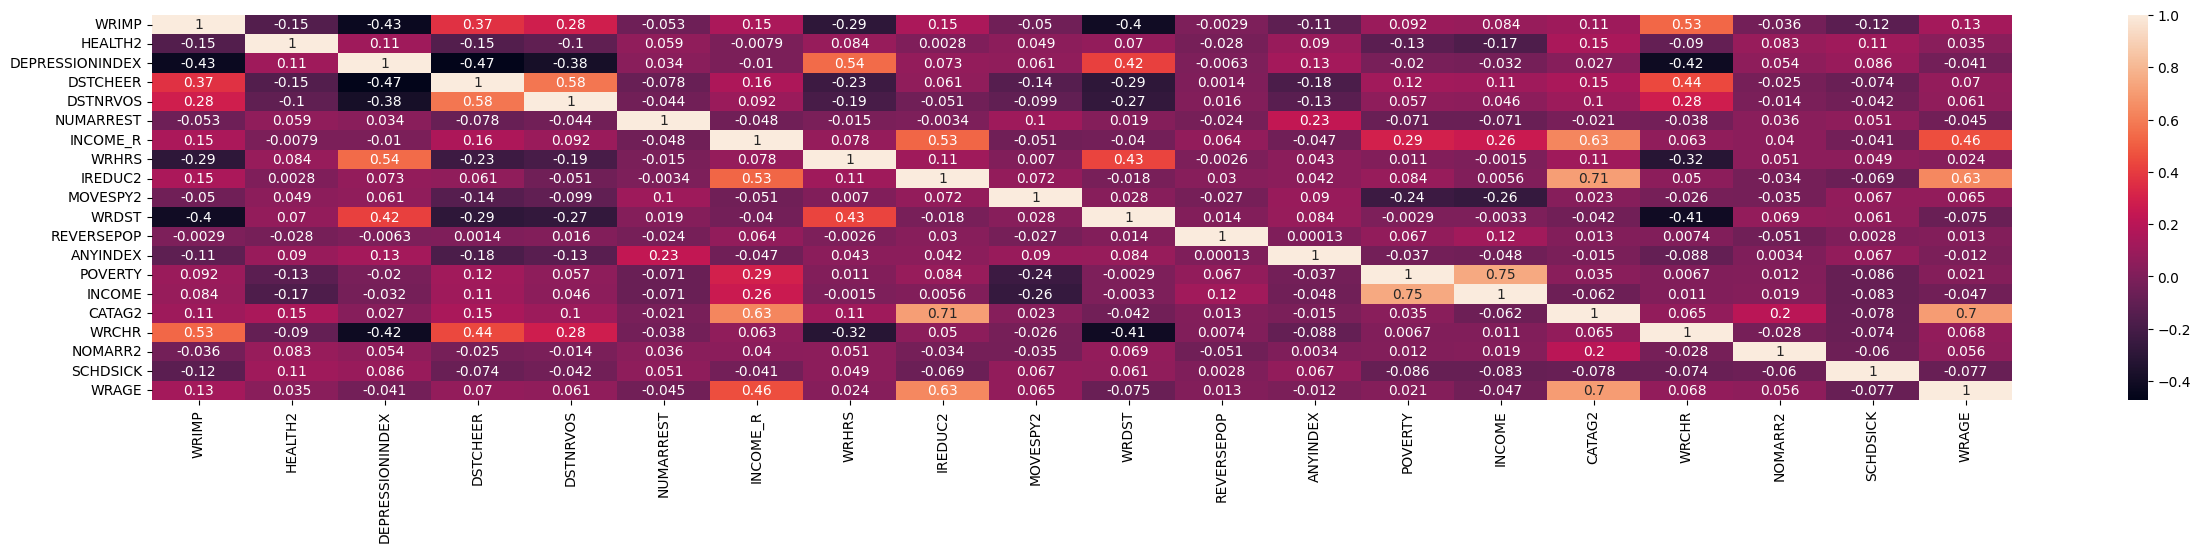

In [64]:
plt.figure(figsize=(30, 5))
sns.heatmap(pearson_df, annot=True)

<Axes: >

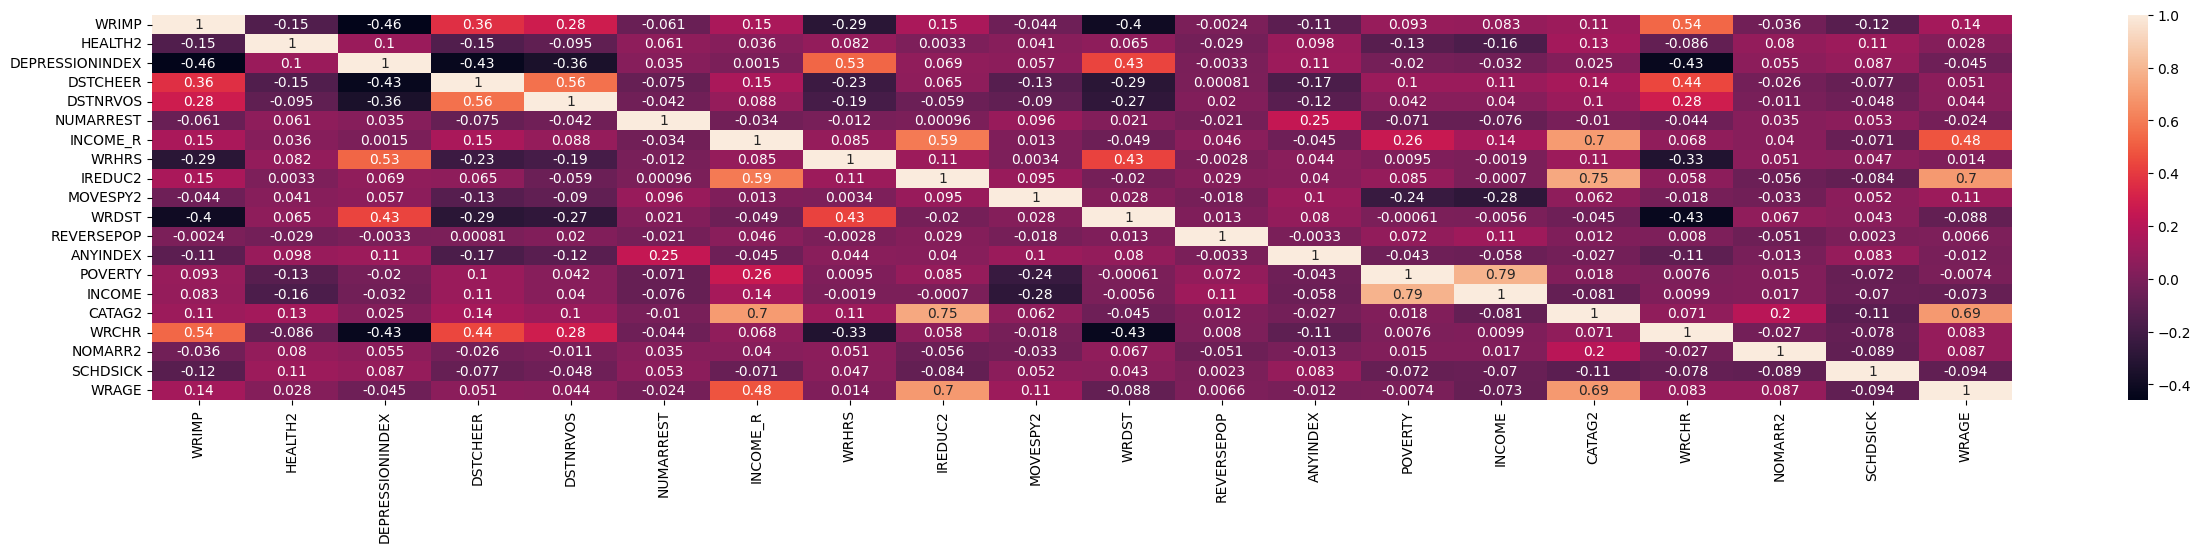

In [65]:
plt.figure(figsize=(30, 5))
sns.heatmap(spearman_df, annot=True)

<Axes: xlabel='ppscore', ylabel='x'>

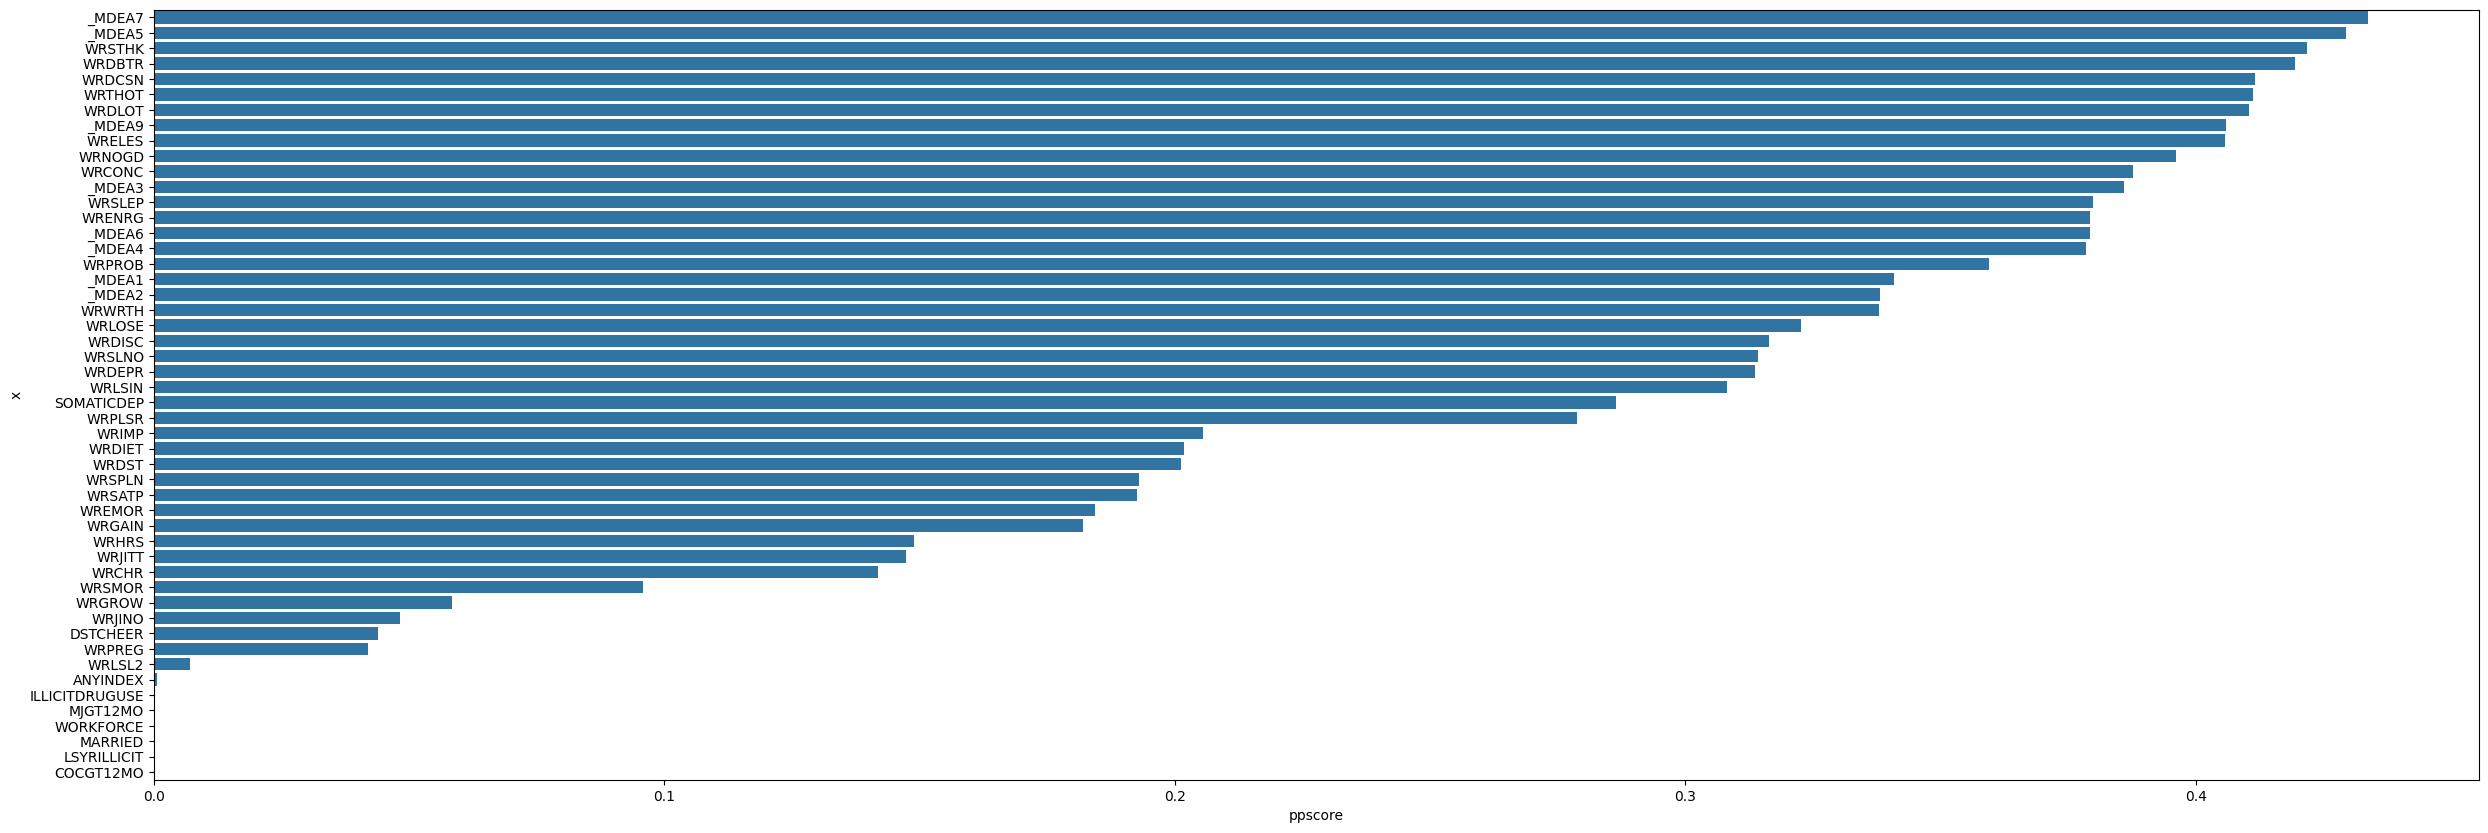

In [66]:
plt.figure(figsize=(30, 10))
sns.barplot(x="ppscore", y="x", data=pps_df.head(50))

### Analysis Performed For Different Groups

In [19]:
def split_by_col(df, col):
    categories = df[col].unique()
    categories.sort()
    dfs = {}
    for category in categories:
        dfs[f"{category}"] = df[df[col] == category].reset_index(drop=True)
    return dfs


def split_by_cols(df, cols):
    dfs = {}
    for col in cols:
        dfs[col] = split_by_col(df, col)
    return dfs

In [20]:
depression_dfs = split_by_cols(depression_df, ["IRSEX", age_col])